# Fig 2: PCA

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
matplotlib.style.use('styles.mplstyle')
import sys
sys.path.append('../')
from helpers import cm2inch, title

In [2]:
def load_contours(fn, num_samples=100):
    df = pd.read_csv(fn)
    contours = df[[str(i) for i in range(num_samples)]].values
    return contours, df

contours, df = load_contours('../data/phrase-contours/boehme-phrase-contours.csv')

In [3]:
def alpha(k, N):
    if k == 0:
        return 1 / np.sqrt(N)
    else:
        return np.sqrt(2/N)
    
def cosine(n, k, N):
    return alpha(k, N) * np.cos(np.pi * (2*n + 1) * k / (2*N))

def dct_matrix(N):
    """Discrete Cosine Transform NxN matrix where every column is a
    discrete cosine function. Columns are normalized, so the output
    is an orthogonal matrix."""
    ns = np.arange(N)
    return np.array([cosine(ns, k, N) for k in ns]).T

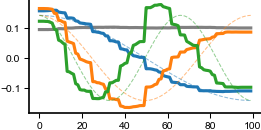

In [4]:
def show_pca(contours, n_components=4):
    pca = PCA(n_components=4)
    pca.fit(contours)
    N = contours.shape[1]
    xs = np.arange(0, N)
    for k in range(n_components):
        comp = pca.components_[k]
        v = cosine(xs, k, N)
        
        if np.linalg.norm(-1*comp - v) < np.linalg.norm(comp - v):
            comp = -1 * comp
    
        color = '0.5' if k == 0 else f'C{k-1}'
        plt.plot(xs, comp, label=f'$C_{k}$', c=color)
        plt.plot(xs, v, c=color, ls='--', alpha=.5, lw=.5)

plt.figure(figsize=(2, 1))
show_pca(contours, n_components=4)

In [5]:
motifs = load_contours('../data/motif-contours/responsory-subset-syllables.csv')
phrases = load_contours('../data/phrase-contours/liber-responsories-phrase-contours.csv')
segments = load_contours('../data/phrase-contours/liber-responsories-random-contours.csv')
songs = load_contours('../data/song-contours/gregobase.csv')
random = load_contours('../data/random-contours/random-lam-12.csv')
datasets = [
    ('1. Motifs', motifs[0], motifs[1]['duration']),
    ['2. Phrases', phrases[0], phrases[1]['phrase_duration']],  
    ['3. Segments', segments[0], segments[1]['phrase_duration']],  
    ['4. Random', random[0], random[1]['duration']],
    ['5. Songs', songs[0], songs[1]['duration']],
]

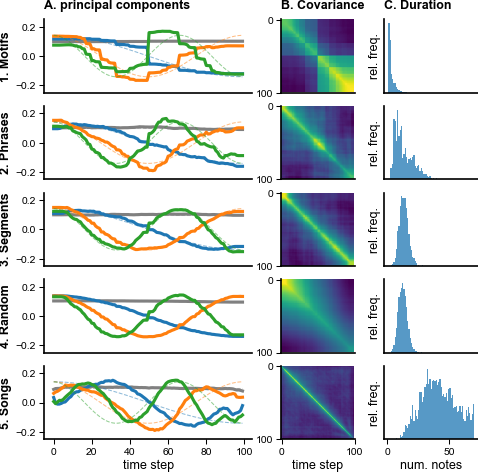

In [6]:
def show_row(contours, durations, row, gs, name, binrange=(1, 40)):
    ax1 = fig.add_subplot(gs[row, :2])
    show_pca(contours)
    plt.ylabel(name, fontweight='bold')
    plt.ylim(-.25, .25)

    ax2 = fig.add_subplot(gs[row, 2])
    plt.imshow(np.cov(contours.T))
    plt.xticks([0, 100])
    plt.yticks([0, 100])

    ax3 = fig.add_subplot(gs[row, 3])
    sns.histplot(durations, stat='probability', 
                 binrange=binrange, bins=binrange[1]-binrange[0], lw=0)
    plt.ylabel('rel. freq.')
    plt.xlabel(None)
    plt.yticks([])

    return ax1, ax2, ax3

def title(text, ax=None, ha='left', x=0, fontweight='bold', **kwargs):
    kwargs = dict(fontweight=fontweight, x=x, ha=ha, **kwargs)
    if ax is None:
        ax = plt.gca()
    ax.set_title(text, **kwargs)

def plot_fig2(datasets):
    gs = gridspec.GridSpec(len(datasets), 4)
    
    for row, (name, contours, durations) in enumerate(datasets):
        binrange = (1, 70) #if row < 3 else (1, 120)
        axes = show_row(contours, durations, row, gs, name, binrange=binrange)
        if row == 0:
            title('A. principal components', ax=axes[0])
            title('B. Covariance', ax=axes[1])
            title('C. Duration', ax=axes[2])
            
        if row == 4:
            axes[0].set_xlabel('time step')
            axes[1].set_xlabel('time step')
            axes[2].set_xlabel('num. notes')
        else:
            axes[0].set_xticks([])
            axes[1].set_xticks([])
            axes[2].set_xticks([])

    plt.tight_layout()
    
fig = plt.figure(figsize=cm2inch(8.2, 8))
plot_fig2(datasets)
plt.tight_layout(pad=0)
plt.savefig('../figures/fig02/fig02-raw.pdf')